In [1]:
# Fundamentals of Data Science Project
# Part created by Anjana Tiha:
# Experimented with IMDB score with features from gross income prediction feature generation stage 
# Dataset: https://www.kaggle.com/deepmatrix/imdb-5000-movie-dataset
# Features:
# Numerical Features: actor1 Facebook likes, actor2 Facebook likes, actor3 Facebook likes, director Facebook likes, budget.
# Text Features (converted to categorical data): actor1 name, actor2 name, actor3 name, director name, country, content rating, language

# Preprocessing-
#  Text Features:
#    - Text data like top 3 actor names, director names, content rating, country and language have been treated as category 
#    - categorical data has been labeled and binarized for each feature column (each item in a feature column has unique label and binary form)
#  Numerical Features:
#    - numerical data have been min max scaled by fitting to minmaxscaler  
#    - rows with missing gross value and any empty major features have been eliminated
#    - preprocessed numerical, categorical data and text data especially for gross prediction with categorical data in mind

# Both numerical and text data has been used for gross prediction/regression.

# Regression Models: Random Forest Regression and Decision Tree Regression.
# Other models tried: SVR

# Evaluation:
#    - 5-Fold Cross Validation
#    - Evaluation Metrics: Mean Absolute Error, Mean Squared Error, Median Absolute Error
#    - Others tried: Explained Var Score, R^2 score have been calculated
# Visualization: 
#    - actor1, actor2, actor3, director, country, content rating, language by mean gross have been visualized.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import tree
from sklearn import linear_model
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, explained_variance_score, r2_score
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer

In [3]:
global minval
global maxval
global min_max_scaler
global catagory_features
global number_features

min_max_scaler = preprocessing.MinMaxScaler()
text_features = ['genre', 'plot_keywords', 'movie_title']
catagory_features = ['actor_1_name', 'actor_2_name', 'actor_3_name', 'director_name', 'country', 'content_rating', 'language']
number_features = ['actor_1_facebook_likes', 'actor_2_facebook_likes', 'actor_3_facebook_likes', 'director_facebook_likes','cast_total_facebook_likes','budget', 'gross']
all_selected_features = ['actor_1_name', 'actor_2_name', 'actor_3_name', 'director_name', 'country', 'content_rating', 'language', 'actor_1_facebook_likes', 'actor_2_facebook_likes', 'actor_3_facebook_likes', 'director_facebook_likes','cast_total_facebook_likes','budget', 'gross', 'genres', "imdb_score"]
eliminate_if_empty_list = ['actor_1_name', 'actor_2_name', 'director_name', 'country', 'actor_1_facebook_likes', 'actor_2_facebook_likes', 'director_facebook_likes','cast_total_facebook_likes', 'gross', "imdb_score"]

#preprocessing
def data_clean(path):
    read_data = pd.read_csv(path)
    select_data = read_data[all_selected_features]
    data = select_data.dropna(axis = 0, how = 'any', subset = eliminate_if_empty_list)
    data = data.reset_index(drop = True)
    for x in catagory_features:
        data[x] = data[x].fillna('None').astype('category')
    for y in number_features:
        data[y] = data[y].fillna(0.0).astype(np.float)
    return data

def preprocessing_numerical_minmax(data):
    global min_max_scaler
    scaled_data = min_max_scaler.fit_transform(data)
    return scaled_data
    
def preprocessing_categorical(data):
    label_encoder = LabelEncoder()
    label_encoded_data = label_encoder.fit_transform(data) 
    label_binarizer = preprocessing.LabelBinarizer()
    label_binarized_data = label_binarizer.fit_transform(label_encoded_data) 
    return label_binarized_data

def preprocessing_text(data):  
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_vectorized_text = tfidf_vectorizer.fit_transform(data)  
    return tfidf_vectorized_text

#regression model training
def regression_without_cross_validation(model, train_data, train_target, test_data): 
    model.fit(train_data, train_target)
    prediction = model.predict(test_data)
    return prediction

def regression_with_cross_validation(model, data, target, n_fold, model_name, pred_type):
    print(pred_type, " (Regression Model: ", model_name)
    cross_val_score_mean_abs_err  = cross_val_score(model, data, target, scoring = 'mean_absolute_error', cv = n_fold) 
    print("\nCross Validation Score (Mean Absolute Error)        : \n", -cross_val_score_mean_abs_err)
    print("\nCross Validation Score (Mean Absolute Error) (Mean) : \n", -cross_val_score_mean_abs_err.mean())
    cross_val_score_mean_sqr_err  = cross_val_score(model, data, target, scoring = 'mean_squared_error', cv = n_fold)  
    print("\nCross Validation Score (Mean Squared Error)         : \n", -cross_val_score_mean_sqr_err)
    print("\nCross Validation Score (Mean Squared Error)  (Mean) : \n", -cross_val_score_mean_sqr_err.mean())
    
def regression_scores(original_val, predicted_val, model_name):
    print("Regression Model Name: ", model_name)
    mean_abs_error = mean_absolute_error(original_val, predicted_val) 
    mean_sqr_error = mean_squared_error(original_val, predicted_val)
    median_abs_error = median_absolute_error(original_val, predicted_val)
    explained_var_score = explained_variance_score(original_val, predicted_val)
    r2__score = r2_score(original_val, predicted_val)
    
    print("\n")
    print("\nRegression Scores(train_test_split):\n")
    print("Mean Absolute Error    :", mean_abs_error)
    print("Mean Squared Error     :", mean_sqr_error)
    print("Median Absolute Error  :", median_abs_error)
    print("Explained Var Score    :", explained_var_score)
    print("R^2 Score              :", r2__score)
    print("\n\n")

#simple task    
def inverse_scaling(scaled_val):
    unscaled_val = min_max_scaler.inverse_transform(scaled_val)
    return unscaled_val

def roundval(value):  
    return value.round()

def to_millions(value):   
    return value / 10000000

#evaluation    
#plotting actual vs predicted for all data
def prediction_performance_plot(original_val, predicted_val, model_name, start, end, n, plot_type, prediction_type):
    #inverse transform and convert to millions
    original_val = to_millions(inverse_scaling(original_val)) 
    predicted_val = to_millions(inverse_scaling(predicted_val))
    print("\n")
    plt.title("\n"+ prediction_type + " Prediction Performance using " + model_name + "(Actual VS Predicted)"+plot_type + "\n")
    if plot_type=="all":
        plt.plot(original_val, c = 'g', label = "Actual")
        plt.plot(predicted_val, c = 'b', label = "Prediction")
    if plot_type=="seq":
        plt.plot(original_val[start : end + 1], c = 'g', label = "Actual")
        plt.plot(predicted_val[start : end + 1], c = 'b', label = "Prediction")
    if plot_type=="random":
        original_val_list = []
        predicted_val_list = []
        for k in range(n):
            i = random.randint(0, len(predicted_val) - 1)
            original_val_list.append(original_val[i])
            predicted_val_list.append(predicted_val[i])
        plt.plot(original_val_list, c = 'g', label = "Actual")
        plt.plot(predicted_val_list, c = 'b', label = "Prediction")
    plt.legend(["Actual", "Predicted"], loc = 'center left', bbox_to_anchor = (1, 0.8))
    plt.ylabel('Prediction (In Millions)', fontsize = 14)
    plt.grid()
    plt.show()


#printing actual vs predicted in a range 
def print_original_vs_predicted(original_val, predicted_val, i, j, n, model_name, print_type, prediction_type):
    #inverse transform and convert to millions
    original_val = to_millions(inverse_scaling(original_val)) 
    predicted_val = to_millions(inverse_scaling(predicted_val))
    
    print("\n"+prediction_type + " Comparision of Actual VS Predicted"+print_type+"\n")
    if print_type=="seq":
        if j<len(predicted_val):
            for k in range(i, j + 1):
                print("Actual" + prediction_type+" : ", original_val[k], ",   Predicted " +prediction_type," : ", predicted_val[k])
    if print_type=="random":
        for k in range(n):
            i = random.randint(0, len(predicted_val) - 1)
            print("Actual ", prediction_type, " : ", original_val[i], ",   Predicted " +prediction_type+" : ", predicted_val[i])
            
            
#plotting actual vs predicted in a randomly using a bar chart          
def bar_plot_original_vs_predicted_rand(original_val, predicted_val, n, model_name, pred_type):  
    #inverse transform and convert to millions
    original_val = to_millions(inverse_scaling(original_val)) 
    predicted_val = to_millions(inverse_scaling(predicted_val))
    original_val_list = []
    predicted_val_list = []
    for k in range(n):
        i = random.randint(0, len(predicted_val) - 1)
        original_val_list.append(original_val[i])
        predicted_val_list.append(predicted_val[i])
    
    original_val_df = pd.DataFrame(original_val_list)
    predicted_val_df = pd.DataFrame(predicted_val_list)
    
    actual_vs_predicted = pd.concat([original_val_df, predicted_val_df], axis = 1)
    
    actual_vs_predicted.plot(kind = "bar", fontsize = 12, color = ['g','b'], width= 0.7)
    plt.title("\nUsing Categorical and Numerical Features\n" + model_name + " : Actual "+ pred_type+ "VS Predicted "+ pred_type+"(Random)")
    plt.ylabel('Gross (In Millions)', fontsize = 14)
    plt.ylabel('Gross (In M', fontsize = 14)
    plt.xticks([])
    plt.legend(["Actual ", "Predicted"], loc = 'center left', bbox_to_anchor = (1, 0.8))
    plt.grid()
    plt.show()
        
#Plot features
#calculate mean
def meanbyfeature(data, feature_name, meanby_feature):
    mean_data = data.groupby(feature_name).mean()
    mean = mean_data[meanby_feature]
    mean_sort = mean.sort(meanby_feature, inplace = False, ascending = False)
    return mean_sort
    
def plot(data, kind, title, n_rows):
    plt.title(title, fontsize = 15)
    data[:n_rows].plot(kind = kind)
    plt.show()
    
def show_features(database):
    print("\n","--------------------------------------------------------------------------------------------------------")
    database.info()
    print("\n","--------------------------------------------------------------------------------------------------------")
    

In [4]:
def preprocessing_catagory(data):
    data_c=0
    for i in range(len(catagory_features)):
        new_data = data[catagory_features[i]]
        new_data_c = preprocessing_categorical(new_data)
        if i == 0:
            data_c=new_data_c
        else:
            data_c = np.append(data_c, new_data_c, 1)
    return data_c

def preprocessing_numerical(data):
    data_list_numerical = list(zip(data['director_facebook_likes'], data['actor_1_facebook_likes'], 
                                   data['actor_2_facebook_likes'], data['actor_3_facebook_likes'], 
                                   data['cast_total_facebook_likes'], data['budget']))

    data_numerical = np.array(data_list_numerical)
    data_numerical = preprocessing_numerical_minmax(data_numerical)
    return data_numerical

def preprocessed_agregated_data(database): 
    numerical_data = preprocessing_numerical(database)
    categorical_data = preprocessing_catagory(database)
    all_data = np.append(numerical_data, categorical_data, 1)
    return all_data

def regr_without_cross_validation_train_test_perform_plot(model, data, target, model_name, pred_type):
    train_data, test_data, train_target, test_target = train_test_split(data, target, test_size = 0.3, random_state = 0) 
    predicted_gross = regression_without_cross_validation(model, train_data, train_target, test_data)
    regression_scores(test_target, predicted_gross, model_name)
    prediction_performance_plot(test_target, predicted_gross, model_name, 200, 250, 0, "seq", pred_type)
    prediction_performance_plot(test_target, predicted_gross, model_name, 0, 0, 100, "random", pred_type)
    print_original_vs_predicted(test_target, predicted_gross, 0, 0, 10, model_name, "random", pred_type)
    bar_plot_original_vs_predicted_rand(test_target, predicted_gross, 20, model_name, pred_type)

In [5]:
path = "movie_metadata.csv"
data = data=data_clean(path)
#data = data[(data.actor_1_facebook_likes > 0.0) & (data.actor_2_facebook_likes > 0.0) & (data.actor_3_facebook_likes > 0.0) & (data.director_facebook_likes > 0.0) & (data.cast_total_facebook_likes > 0.0) & (data.gross > 0.0)]
target_gross = data['gross']
target_imdb_score = data['imdb_score']
database = data.drop('gross', 1)
database = data.drop('imdb_score', 1)
preprocessed_data = preprocessed_agregated_data(database)
target_gross = preprocessing_numerical_minmax(target_gross)
target_imdb_score = preprocessing_numerical_minmax(target_imdb_score)
print("feature calculation complete\n")

feature calculation complete



C:\Users\Anjana\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\Anjana\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\Anjana\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single 

(Movie Gross Prediction)  (Regression Model:  Random Forest Regression


C:\Users\Anjana\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Anjana\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Anjana\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Anjana\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Anjana\Anaconda


Cross Validation Score (Mean Absolute Error)        : 
 [ 0.08092118  0.03989556  0.03405078  0.02565351  0.0183756 ]

Cross Validation Score (Mean Absolute Error) (Mean) : 
 0.0397793253933


C:\Users\Anjana\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Anjana\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Anjana\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Anjana\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Anjana\Anaconda3\lib\si


Cross Validation Score (Mean Squared Error)         : 
 [ 0.01628134  0.00346775  0.00324112  0.00203942  0.00103401]

Cross Validation Score (Mean Squared Error)  (Mean) : 
 0.00521272762394
Regression Model Name:  Random Forest Regression



Regression Scores(train_test_split):

Mean Absolute Error    : 0.0365358694066
Mean Squared Error     : 0.00403529940142
Median Absolute Error  : 0.0196757734428
Explained Var Score    : 0.492855258272
R^2 Score              : 0.472119214119







C:\Users\Anjana\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\Anjana\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


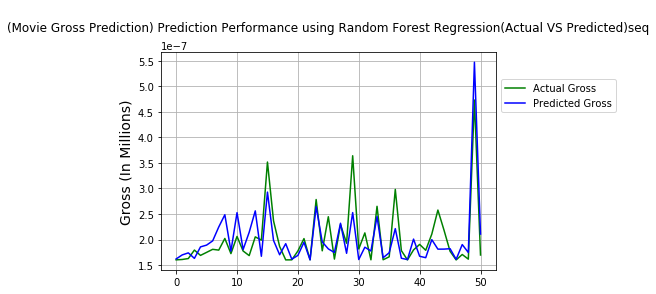

C:\Users\Anjana\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\Anjana\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


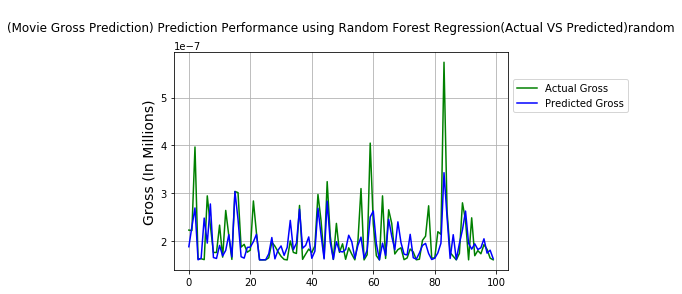

C:\Users\Anjana\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\Anjana\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)



(Movie Gross Prediction) Comparision of Actual VS Predictedrandom

Actual  (Movie Gross Prediction)  :  5.4500966973e-07 ,   Predicted (Movie Gross Prediction) :  4.58727948719e-07
Actual  (Movie Gross Prediction)  :  2.11449512859e-07 ,   Predicted (Movie Gross Prediction) :  1.97365612435e-07
Actual  (Movie Gross Prediction)  :  2.02336724636e-07 ,   Predicted (Movie Gross Prediction) :  2.15265535501e-07
Actual  (Movie Gross Prediction)  :  1.69759416328e-07 ,   Predicted (Movie Gross Prediction) :  1.89357265278e-07
Actual  (Movie Gross Prediction)  :  2.02694720829e-07 ,   Predicted (Movie Gross Prediction) :  1.99453124542e-07
Actual  (Movie Gross Prediction)  :  1.92372844208e-07 ,   Predicted (Movie Gross Prediction) :  1.64119514418e-07
Actual  (Movie Gross Prediction)  :  2.24623229463e-07 ,   Predicted (Movie Gross Prediction) :  1.84649680743e-07
Actual  (Movie Gross Prediction)  :  1.63874061257e-07 ,   Predicted (Movie Gross Prediction) :  1.60948378922e-07
Actual  (Movi

C:\Users\Anjana\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\Anjana\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


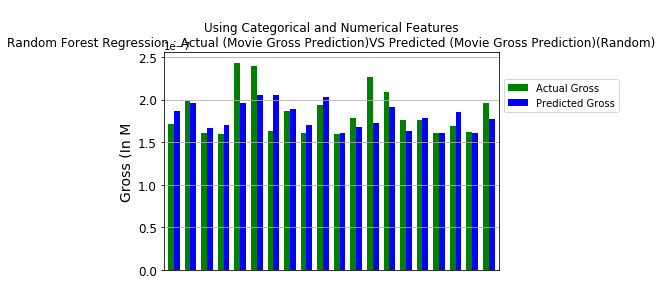

(Movie Gross Prediction)  (Regression Model:  Decision Tree Regression


C:\Users\Anjana\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Anjana\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Anjana\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Anjana\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Anjana\Anaconda


Cross Validation Score (Mean Absolute Error)        : 
 [ 0.09633492  0.04798551  0.03921903  0.02851436  0.01833756]

Cross Validation Score (Mean Absolute Error) (Mean) : 
 0.0460782734267


C:\Users\Anjana\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Anjana\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Anjana\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Anjana\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Anjana\Anaconda3\lib\si


Cross Validation Score (Mean Squared Error)         : 
 [ 0.0186914   0.00476883  0.0043426   0.00264733  0.00122087]

Cross Validation Score (Mean Squared Error)  (Mean) : 
 0.00633420578712
Regression Model Name:  Decision Tree Regression



Regression Scores(train_test_split):

Mean Absolute Error    : 0.042119309811
Mean Squared Error     : 0.00624189183426
Median Absolute Error  : 0.0199948774873
Explained Var Score    : 0.2106009184
R^2 Score              : 0.183462132775


C:\Users\Anjana\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\Anjana\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


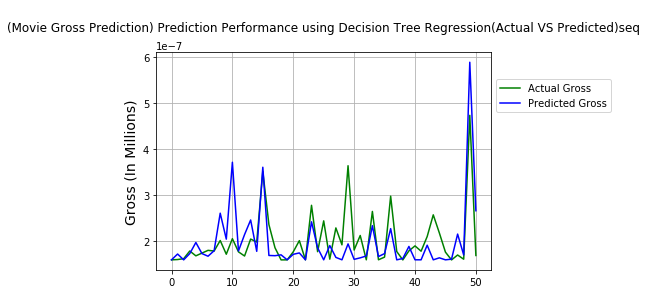

C:\Users\Anjana\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\Anjana\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


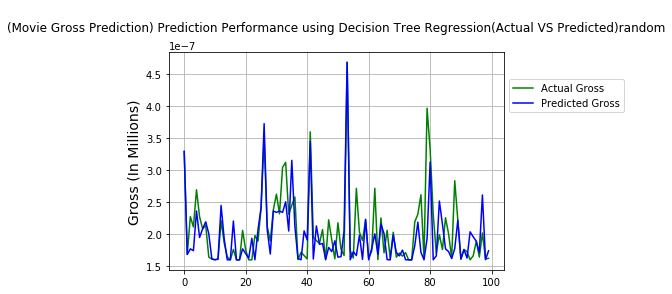

C:\Users\Anjana\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\Anjana\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)



(Movie Gross Prediction) Comparision of Actual VS Predictedrandom

Actual  (Movie Gross Prediction)  :  1.65420715941e-07 ,   Predicted (Movie Gross Prediction) :  1.69822511307e-07
Actual  (Movie Gross Prediction)  :  1.72340643581e-07 ,   Predicted (Movie Gross Prediction) :  2.05004759248e-07
Actual  (Movie Gross Prediction)  :  1.61326463667e-07 ,   Predicted (Movie Gross Prediction) :  1.60208929311e-07
Actual  (Movie Gross Prediction)  :  1.83366244317e-07 ,   Predicted (Movie Gross Prediction) :  1.85919431832e-07
Actual  (Movie Gross Prediction)  :  2.41049370367e-07 ,   Predicted (Movie Gross Prediction) :  2.41049370367e-07
Actual  (Movie Gross Prediction)  :  2.23232831468e-07 ,   Predicted (Movie Gross Prediction) :  1.85434746527e-07
Actual  (Movie Gross Prediction)  :  2.00187500097e-07 ,   Predicted (Movie Gross Prediction) :  1.83163255407e-07
Actual  (Movie Gross Prediction)  :  1.70222986275e-07 ,   Predicted (Movie Gross Prediction) :  1.60029433929e-07
Actual  (Mov

C:\Users\Anjana\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\Anjana\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


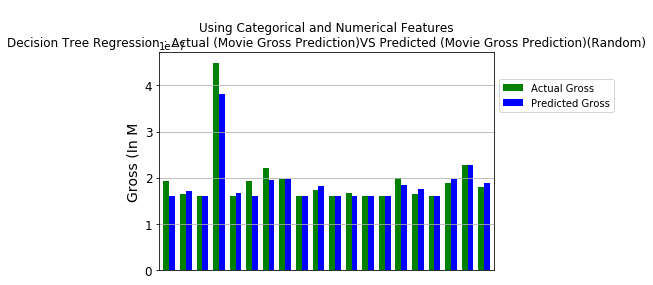

In [6]:
#print("________________Random Forest Regressor Model(Gross Predeiction)_________________________")
randomForestRegressorModel = RandomForestRegressor()
regression_with_cross_validation(randomForestRegressorModel, preprocessed_data, target_gross, 5, "Random Forest Regression", "(Movie Gross Prediction)")
regr_without_cross_validation_train_test_perform_plot(randomForestRegressorModel, preprocessed_data, target_gross,"Random Forest Regression", "(Movie Gross Prediction)")
#print("_____________________________________________________________________________________________________________________")
#print("_____________________________________________________________________________________________________________________")
#print("__________________________Decision Tree Regressor Model(Gross Predeiction)_______________________________")
#print("")
DecisionTreeRegressorModel = tree.DecisionTreeRegressor()
regression_with_cross_validation(DecisionTreeRegressorModel, preprocessed_data, target_gross, 5, "Decision Tree Regression", "(Movie Gross Prediction)")
regr_without_cross_validation_train_test_perform_plot(DecisionTreeRegressorModel, preprocessed_data, target_gross, "Decision Tree Regression", "(Movie Gross Prediction)")


(IMDB Score Prediction)  (Regression Model:  Random Forest Regression


C:\Users\Anjana\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Anjana\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Anjana\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Anjana\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Anjana\Anaconda


Cross Validation Score (Mean Absolute Error)        : 
 [ 0.09494289  0.08683461  0.09508215  0.09500078  0.09741668]

Cross Validation Score (Mean Absolute Error) (Mean) : 
 0.0938554216867


C:\Users\Anjana\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Anjana\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Anjana\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Anjana\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Anjana\Anaconda3\lib\si


Cross Validation Score (Mean Squared Error)         : 
 [ 0.01438072  0.01318487  0.01608859  0.0166247   0.0160606 ]

Cross Validation Score (Mean Squared Error)  (Mean) : 
 0.0152678958031
Regression Model Name:  Random Forest Regression



Regression Scores(train_test_split):

Mean Absolute Error    : 0.092268293955
Mean Squared Error     : 0.0150413155405
Median Absolute Error  : 0.074025974026
Explained Var Score    : 0.163265839792
R^2 Score              : 0.156944178381







C:\Users\Anjana\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\Anjana\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


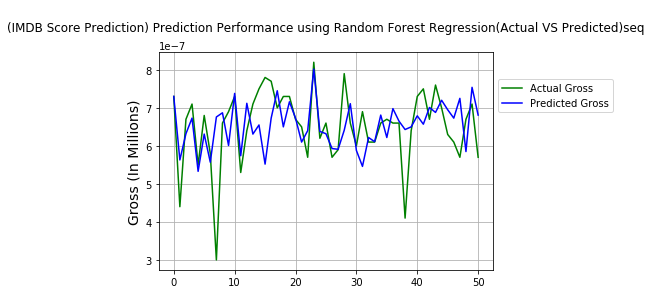

C:\Users\Anjana\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\Anjana\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


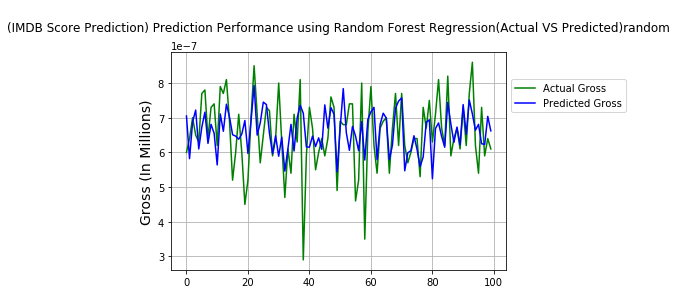

C:\Users\Anjana\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\Anjana\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)



(IMDB Score Prediction) Comparision of Actual VS Predictedrandom

Actual  (IMDB Score Prediction)  :  4.3e-07 ,   Predicted (IMDB Score Prediction) :  5.38e-07
Actual  (IMDB Score Prediction)  :  7.5e-07 ,   Predicted (IMDB Score Prediction) :  8.06e-07
Actual  (IMDB Score Prediction)  :  6.3e-07 ,   Predicted (IMDB Score Prediction) :  5.68e-07
Actual  (IMDB Score Prediction)  :  5.5e-07 ,   Predicted (IMDB Score Prediction) :  6.76e-07
Actual  (IMDB Score Prediction)  :  5.5e-07 ,   Predicted (IMDB Score Prediction) :  5.47e-07
Actual  (IMDB Score Prediction)  :  6.3e-07 ,   Predicted (IMDB Score Prediction) :  6.95e-07
Actual  (IMDB Score Prediction)  :  7.1e-07 ,   Predicted (IMDB Score Prediction) :  6.68e-07
Actual  (IMDB Score Prediction)  :  7.2e-07 ,   Predicted (IMDB Score Prediction) :  6.68e-07
Actual  (IMDB Score Prediction)  :  7.5e-07 ,   Predicted (IMDB Score Prediction) :  7.05e-07
Actual  (IMDB Score Prediction)  :  7.1e-07 ,   Predicted (IMDB Score Prediction) :  5.

C:\Users\Anjana\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\Anjana\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


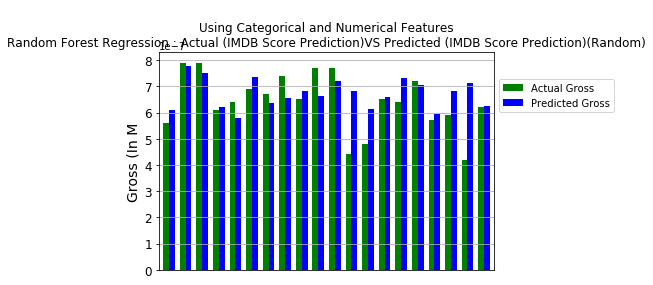

(IMDB Score Prediction)  (Regression Model:  Decision Tree Regression


C:\Users\Anjana\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Anjana\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Anjana\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Anjana\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Anjana\Anaconda


Cross Validation Score (Mean Absolute Error)        : 
 [ 0.12348615  0.11165702  0.11049914  0.11539665  0.1119856 ]

Cross Validation Score (Mean Absolute Error) (Mean) : 
 0.114604913159


C:\Users\Anjana\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Anjana\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Anjana\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Anjana\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Anjana\Anaconda3\lib\si


Cross Validation Score (Mean Squared Error)         : 
 [ 0.02338821  0.02115008  0.02235794  0.0236414   0.02379239]

Cross Validation Score (Mean Squared Error)  (Mean) : 
 0.0228660027189
Regression Model Name:  Decision Tree Regression



Regression Scores(train_test_split):

Mean Absolute Error    : 0.112387211182
Mean Squared Error     : 0.022529517632
Median Absolute Error  : 0.0909090909091
Explained Var Score    : -0.255411774371
R^2 Score              : -0.262764613032







C:\Users\Anjana\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\Anjana\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


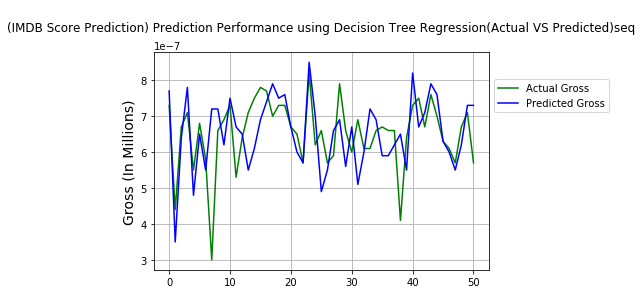

C:\Users\Anjana\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\Anjana\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


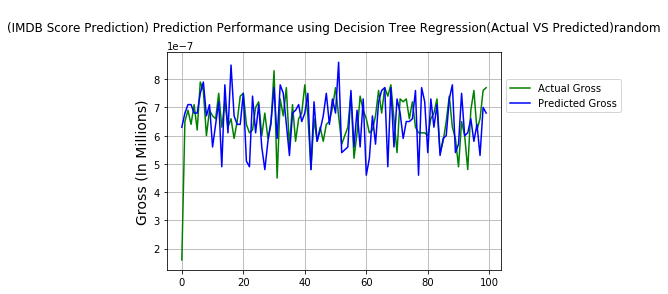

C:\Users\Anjana\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\Anjana\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)



(IMDB Score Prediction) Comparision of Actual VS Predictedrandom

Actual  (IMDB Score Prediction)  :  6.7e-07 ,   Predicted (IMDB Score Prediction) :  6.2e-07
Actual  (IMDB Score Prediction)  :  6.6e-07 ,   Predicted (IMDB Score Prediction) :  7.6e-07
Actual  (IMDB Score Prediction)  :  6.9e-07 ,   Predicted (IMDB Score Prediction) :  6.6e-07
Actual  (IMDB Score Prediction)  :  6.8e-07 ,   Predicted (IMDB Score Prediction) :  7.2e-07
Actual  (IMDB Score Prediction)  :  5.8e-07 ,   Predicted (IMDB Score Prediction) :  7.3e-07
Actual  (IMDB Score Prediction)  :  6.7e-07 ,   Predicted (IMDB Score Prediction) :  6.6e-07
Actual  (IMDB Score Prediction)  :  6.9e-07 ,   Predicted (IMDB Score Prediction) :  7.1e-07
Actual  (IMDB Score Prediction)  :  8.1e-07 ,   Predicted (IMDB Score Prediction) :  7.4e-07
Actual  (IMDB Score Prediction)  :  7.6e-07 ,   Predicted (IMDB Score Prediction) :  5.8e-07
Actual  (IMDB Score Prediction)  :  7.8e-07 ,   Predicted (IMDB Score Prediction) :  6.9e-07


C:\Users\Anjana\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\Anjana\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


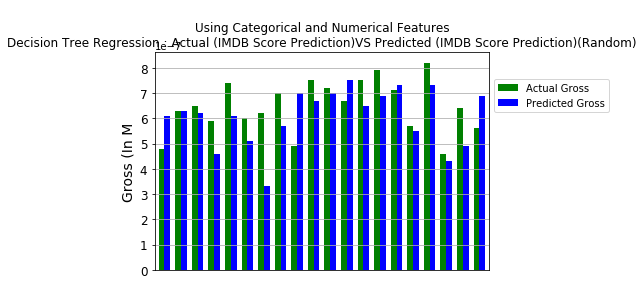

In [8]:

#print("_______________________Random Forest Regressor Model(IMDB Score Prediction)____________________________________")
randomForestRegressorModel = RandomForestRegressor()
regression_with_cross_validation(randomForestRegressorModel, preprocessed_data, target_imdb_score, 5, "Random Forest Regression", "(IMDB Score Prediction)")
regr_without_cross_validation_train_test_perform_plot(randomForestRegressorModel, preprocessed_data, target_imdb_score,"Random Forest Regression", "(IMDB Score Prediction)")
#print("_______________________________________________________________________________________________________________")
#print("_________________________________________________________________________________________________________________")
#print("_______________________Decision Tree Regressor Model(IMDB Score Prediction)_____________________________________")
#print("")
DecisionTreeRegressorModel = tree.DecisionTreeRegressor()
regression_with_cross_validation(DecisionTreeRegressorModel, preprocessed_data, target_imdb_score, 5, "Decision Tree Regression", "(IMDB Score Prediction)")
regr_without_cross_validation_train_test_perform_plot(DecisionTreeRegressorModel, preprocessed_data, target_imdb_score, "Decision Tree Regression", "(IMDB Score Prediction)")


In [ ]:
#Plotting
actor_1_gross_mean_sort = meanbyfeature(data, 'actor_1_name', 'gross')
plot(actor_1_gross_mean_sort, 'bar', 'Actor 1 Sorted by Mean Gross', 30)


In [ ]:

actor_2_gross_mean_sort = meanbyfeature(data, 'actor_2_name', 'gross')
plot(actor_2_gross_mean_sort, 'bar', 'Actor 2 Sorted by Mean Gross', 30)


In [ ]:

actor_3_gross_mean_sort = meanbyfeature(data, 'actor_3_name', 'gross')
plot(actor_3_gross_mean_sort, 'bar', 'Actor 3 Sorted by Mean Gross', 30)


In [ ]:

director_gross_sort = meanbyfeature(data, 'director_name', 'gross')
plot(director_gross_sort, 'bar', 'Director sorted by mean gross', 30)


In [ ]:

country_gross_sort = meanbyfeature(data, 'country', 'gross')
plot(country_gross_sort, 'bar', 'Country sorted by mean gross', 30)


In [ ]:

content_rating_gross_sort = meanbyfeature(data, 'content_rating', 'gross')
plot(content_rating_gross_sort, 'bar', 'Content Rating Sorted by Mean Gross', 30)


In [ ]:
corr = data.corr()
c = plt.matshow(corr)
plt.colorbar(c)
plt.show()